<a href="https://colab.research.google.com/github/arangoml/arangopipe/blob/master/examples/Arangopipe_Feature_ext2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install python-arango
!pip install arangopipe==0.0.6.9.3
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle

## Intro
We use a few terms throughout this notebook that will be helpful to be aware of, and this section explains some of them. Machine learning is frequently applied to perform supervised learning. Supervised learning involves training a model to predict an entity of interest, given other entities that we think can be used to predict it. 

## Model Parameters
The entity of interest is called the **target**. The entities that we use to predict it are called **predictors**. 

When the target can take a continuous range of values, the learning task is called **regression**. Examples of targets that could take a continuous range of values include:
* House prices
* Cholesterol level in a blood sample
* Customers online shopping budget

In contrast, there are applications where the target can only take one of a fixed set of values. In this case, the target is **discrete** or **categorical** in contrast to being continuous. Examples of discrete targets would be: 
* The threat level of a request that is received (intruder/benign)
* Disease status of an individual (infected/not-infected) 

When the target is discrete or categorical, the learning task is called **classification**.
We will start our machine learning series with a regression example. In [part 2 of this series](https://www.arangodb.com/2020/10/arangoml-part-2-basic-arangopipe-machine-learning-workflow/), we developed a regression model using [LASSO regression](https://en.wikipedia.org/wiki/Lasso_(statistics). 

## Covariate Shift
When developing a model, we determine the model’s parameters as part of the training process. The model parameters are estimated from the data and are the coefficients associated with the regression line. 

However, the data in the training sample may not be representative of the data the application is receiving now; for reasons such as:
* The data we collected initially may be subject to sampling biases. 
* We may have intentionally or unintentionally made mistakes in collecting the data.
* Market and business conditions have changed and the pricing of the same houses is different.

It is possible to account for variances between the years with your predictors, but the model becomes inaccurate if the underlying data distribution changes too much. This potential inaccuracy due to the changing or updating of data is a **covariate shift**. As you can imagine, it is crucial to make sure your model provides accurate results as you receive more data in production. That is why we will look at detecting covariate shifts in datasets throughout the rest of this notebook. 

## The Dataset
We will continue with the dataset we have been using in this series, the California housing dataset. The following code block imports a random sample of 500 lines from the data and prints just a snapshot to visualize the dataset’s information. 

This dataset is available from the arangopipe repo and was initially made available from the UCI ML Repository. The dataset contains data for housing in California, including:
* The house configuration & location
* The median house values and ages
* The general population & number of households
* The median income for the area


In [2]:
import pandas as pd
import numpy as np
data_url = "https://raw.githubusercontent.com/arangoml/arangopipe/arangopipe_examples/examples/data/cal_housing.csv"
df = pd.read_csv(data_url, error_bad_lines=False)
df = df.sample(n = 500)
df.head()

,lat,long,housingMedAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
361,-122.12,37.75,28,794,111,329,109,7.6923,329800.0
18968,-122.02,38.26,20,3899,763,2198,779,3.2061,120400.0
3349,-120.77,40.65,11,2635,667,280,132,1.7214,118300.0
20524,-121.56,38.44,43,1485,270,653,251,3.0000,141700.0
14244,-117.10,32.70,42,2002,488,1505,464,1.5057,86300.0


## Let's Get Started

Ok, so all that is well and good, but how do we detect that the underlying dataset distribution changed? We can employ a simple technique to do that.

This post will illustrate how a dataset shift can occur and how you can identify it. As discussed earlier, a dataset shift can occur due to sampling errors. For this example, we will deliberately make a sampling error when we acquire the training data used to develop the model. After model development, we receive a new batch of data. The question we will answer is:

**Is the current batch of data different in a distributional sense from the one used to build the current model?**

We will use machine learning to solve this problem! 

Here are some of the steps we will take.

1. Tag the data from the batch used to build the current production model as 0. 
2. Tag the batch of data that we have received since then as 1. 
3. Develop a model to discriminate between these two labels.
4. Evaluate the results and adjust the model if necessary. 

If the model we develop can discriminate too well between the two batches of data, then a covariate shift has occurred, and we need to revisit modeling. 

If the model cannot discriminate well between these two batches, for example, the classifier we develop produces an accuracy of about  0.5, then this classifier is not very discriminatory. It only performs as well as tossing a fair coin. If we observe such a result, then we conclude that a sufficient dataset shift has not occurred, and our current model will serve us well.

We illustrate this idea with the California housing dataset. The machine learning task associated with the dataset is to predict the median house value given a set of predictors. The rest of the notebook illustrates the idea discussed above.


##  Exploring the Data

Let's take some time to explore the data a bit. First, we look at the types and shapes of the data to see what is available. 

In [3]:

req_cols = df.columns.tolist()
req_cols.remove("medianHouseValue")
df = df[req_cols]
df.dtypes

lat              float64
long             float64
housingMedAge      int64
totalRooms         int64
totalBedrooms      int64
population         int64
households         int64
medianIncome     float64
dtype: object

In [4]:
df["lat"].describe()

count    500.000000
mean    -119.538660
std        2.032065
min     -124.300000
25%     -121.830000
50%     -118.440000
75%     -118.027500
max     -115.370000
Name: lat, dtype: float64

When we plot the histogram of the lat variable, we see two populations (see below):
1. A group with lat values less than -119
2. A group with lat values greater than -119 

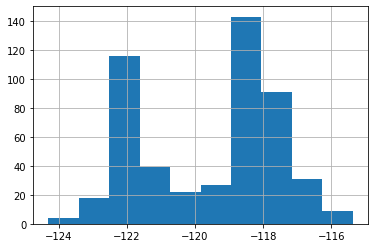

In [5]:

import matplotlib.pyplot as plt
%matplotlib inline  
df["lat"].hist()

Let’s pretend that the current batch of data used to develop our regression model is the first one, the group with lat values less than -119. By not selecting any houses with lat values greater than -119, we have introduced a sampling error. When selecting data for model development, you would want to use the entire range of lat values. Our second group consists of houses with lat values greater than -119.

In [6]:
df1 = df.query("lat <= -119")
df2 = df.query("lat > -119")

Can we discriminate between the two? 

Let’s develop a classifier and see if we can. 

## Using the dataset shift API
Here we use a [random forest classifier](https://en.wikipedia.org/wiki/Random_forest) and our Dataset Shift Detector to test our data and then print the returned score value. 

In [7]:
from arangopipe.arangopipe_analytics.rf_dataset_shift_detector import RF_DatasetShiftDetector

rfd = RF_DatasetShiftDetector()
score = rfd.detect_dataset_shift(df1, df2)
print ("Detaset shift score : %2.2f" % (score))

Detaset shift score : 1.00


## Interpretation of the score reported by the shift detector
The API uses a classifier to discriminate between the datasets provided to it. The score reported by the API is the accuracy of the classifier to discriminate between the datasets. Values close to  0.5  indicate that the classifier is not able to discriminate between the two datasets. This could be interpreted as a situation where no discernable shift has occurred in the data since the last model deployment. Values close to 1 indicate that the dataset shift is detectable, and we may need to revisit modeling. 

How the dataset shift affects the performance of the deployed model is problem-dependent. So we must assess the score in the context of a particular application. Usually, we perform experiments to determine a threshold value of the dataset shift score; the score represents an acceptable level of drift.

## Conclusion
This post introduced covariate shifts in datasets and provided an example of how easy it is to test this with ArangoML’s built-in API. The [Introduction to ArangoML series](https://www.arangodb.com/tag/arangoml/) will continue, so be sure to sign up for our newsletter to be notified of the next release!

You can also join us on the [ArangoML Slack channel](https://arangodb-community.slack.com/archives/CN9LVJ24S) if you have any questions or comments.

If you have something cool you are working on with ArangoML or ArangoDB in general we would love to learn about it. We now have an [interactive tutorials repository](https://github.com/arangodb/interactive_tutorials) where you can share your own notebook with the community, [check it out](https://github.com/arangodb/interactive_tutorials)!